# <u>Deep Love</u>

# Base Imports

In [174]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import tensorflow_hub as hub
import spacy
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [175]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history, metrics = ['accuracy', 'F1']):
  plt.figure(figsize=(14, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.history[metric], color=colors[0], label='train')
    plt.plot(history.history['val_'+metric],
             color=colors[0], linestyle="--", label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Load Data

In [176]:
TRAIN_SIZE = 0.85
PATH = 'data/'

#"Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"
classes = ["Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]
data_train = pd.read_csv(PATH+'tweets_train.csv')

train_data = data_train.sample(frac=1).reset_index(drop=True)
train_data, val_data = train_data.iloc[:int(TRAIN_SIZE*len(train_data)), :], train_data.iloc[int(TRAIN_SIZE*len(train_data)):, :]

print(data_train.shape)
print(train_data.shape)
print(val_data.shape)

(2256, 10)
(1917, 10)
(339, 10)


# Exploración de datos

In [177]:
from random import randint

row_num = data_train.shape[0]
initial = randint(0, row_num-5)
for i in range(initial, initial+5):
    print("Tweet", i+1)
    print(data_train["text"].iloc[i])
    print("Odio:", data_train["Odio"].iloc[i], " "
          "Mujeres:", data_train["Mujeres"].iloc[i], " "
          "LGBT:", data_train["Comunidad LGBTQ+"].iloc[i], " ",
          "Migrantes:", data_train["Comunidades Migrantes"].iloc[i], " ",
          "Pueblos Originarios:", data_train["Pueblos Originarios"].iloc[i])
    print()

Tweet 686
Su perra madre
Odio: 1  Mujeres: 1  LGBT: 0   Migrantes: 0   Pueblos Originarios: 0

Tweet 687
Me encanta cuando cojo indriver y es una mujer 💕💕💕💕💕💕💕 las señoras indriver 💝
Odio: 0  Mujeres: 3  LGBT: 0   Migrantes: 0   Pueblos Originarios: 0

Tweet 688
@daandico @FEquidad Eso no lo hace un espacio público, que los curitas le permitan pasar es lo mismo que si fuera una gasolinera que quede en una esquina y pueda cruzar en diagonal. Eso no significa que la gasolinera sea pública
Odio: 0  Mujeres: 0  LGBT: 0   Migrantes: 0   Pueblos Originarios: 0

Tweet 689
@whstlmila mi mujer
Odio: 0  Mujeres: 0  LGBT: 0   Migrantes: 0   Pueblos Originarios: 0

Tweet 690
@janomatusmc Y Así estos flojos clos, quieren más regalías💲💰💰, malditos 😡😡😡. Fuerza Tere y paciencia con los pueblos originarios se pueden cansar🪑🪑 con tantos viajes🛏🛏🛋🛋
Odio: 3  Mujeres: 0  LGBT: 0   Migrantes: 0   Pueblos Originarios: 3



In [178]:
MIN_VOTOS = 2

num_odio = data_train["Odio"][data_train["Odio"] >= MIN_VOTOS].count()
num_mujeres = data_train["Mujeres"][data_train["Mujeres"] >= MIN_VOTOS].count()
num_lgbt = data_train["Comunidad LGBTQ+"][data_train["Comunidad LGBTQ+"] >= MIN_VOTOS].count()
num_migrantes = data_train["Comunidades Migrantes"][data_train["Comunidades Migrantes"] >= MIN_VOTOS].count()
num_pueblos = data_train["Pueblos Originarios"][data_train["Pueblos Originarios"] >= MIN_VOTOS].count()
sin_categoria = data_train["Odio"][data_train["Odio"] < MIN_VOTOS][data_train["Mujeres"] < MIN_VOTOS][data_train["Comunidad LGBTQ+"] < MIN_VOTOS][data_train["Comunidades Migrantes"] < MIN_VOTOS][data_train["Pueblos Originarios"] < MIN_VOTOS].count()

print("Numero de tweets por categoria:")
print("Odio:", num_odio)
print("Mujeres:", num_mujeres)
print("LGBTQ+:", num_lgbt)
print("Migrantes:", num_migrantes)
print("Pueblos Originarios:", num_pueblos)
print("Sin categoria:", sin_categoria)

num_odio_mujeres = data_train["Mujeres"][data_train["Odio"] >= MIN_VOTOS][data_train["Mujeres"] >= MIN_VOTOS].count()
num_odio_lgbt = data_train["Comunidad LGBTQ+"][data_train["Odio"] >= MIN_VOTOS][data_train["Comunidad LGBTQ+"] >= MIN_VOTOS].count()
num_odio_migrantes = data_train["Comunidades Migrantes"][data_train["Odio"] >= MIN_VOTOS][data_train["Comunidades Migrantes"] >= MIN_VOTOS].count()
num_odio_pueblos = data_train["Pueblos Originarios"][data_train["Odio"] >= MIN_VOTOS][data_train["Pueblos Originarios"] >= MIN_VOTOS].count()
odio_sin_categoria = data_train["Odio"][data_train["Odio"] >= MIN_VOTOS][data_train["Mujeres"] < MIN_VOTOS][data_train["Comunidad LGBTQ+"] < MIN_VOTOS][data_train["Comunidades Migrantes"] < MIN_VOTOS][data_train["Pueblos Originarios"] < MIN_VOTOS].count()


print("\nNumero de tweets de odio hacia:")
print("Mujeres:", num_odio_mujeres, "(", 100 * num_odio_mujeres/num_mujeres, "%)")
print("LGBTQ+:", num_odio_lgbt, "(", 100 * num_odio_lgbt/num_lgbt, "%)")
print("Migrantes:", num_odio_migrantes, "(", 100 * num_odio_migrantes/num_migrantes, "%)")
print("Pueblos Originarios:", num_odio_pueblos, "(", 100 * num_odio_pueblos/num_pueblos, "%)")
print("Sin categoria:", odio_sin_categoria, "(", 100 * odio_sin_categoria/sin_categoria, "%)")

Numero de tweets por categoria:
Odio: 999
Mujeres: 468
LGBTQ+: 155
Migrantes: 327
Pueblos Originarios: 290
Sin categoria: 1009

Numero de tweets de odio hacia:
Mujeres: 297 ( 63.46153846153846 %)
LGBTQ+: 129 ( 83.2258064516129 %)
Migrantes: 291 ( 88.9908256880734 %)
Pueblos Originarios: 274 ( 94.48275862068965 %)
Sin categoria: 42 ( 4.162537165510407 %)


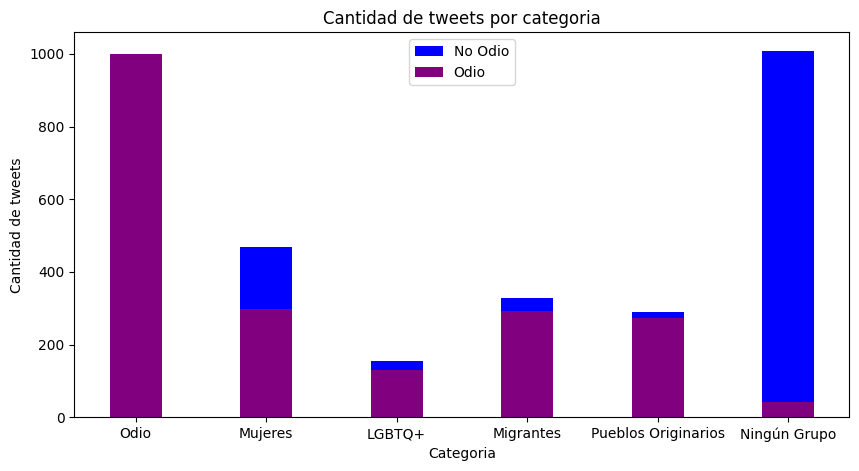

In [179]:
tweets_by_category = [num_odio, num_mujeres, num_lgbt, num_migrantes, num_pueblos, sin_categoria]
tweets_by_category_odio = [num_odio, num_odio_mujeres, num_odio_lgbt, num_odio_migrantes, num_odio_pueblos, odio_sin_categoria]
categories = ["Odio", "Mujeres", "LGBTQ+", "Migrantes", "Pueblos Originarios", "Ningún Grupo"]

plt.figure(figsize=(10, 5))
plt.bar(categories, tweets_by_category, color='blue', width=0.4)
plt.bar(categories, tweets_by_category_odio, color='purple', width=0.4)
plt.title("Cantidad de tweets por categoria")
plt.xlabel("Categoria")
plt.ylabel("Cantidad de tweets")
# add a legend
plt.legend(["No Odio", "Odio"])
plt.show()

# Preprocess Data

## Conversión a Multi-Hot Encoding

In [180]:
MIN_VOTOS = 2

if MIN_VOTOS == 3:
    # Considerar que un dato pertenece solo si las 3 personas pusieron que pertenece
    train_data['Odio'] = np.where(train_data['Odio'] == 3, 1, 0)
    val_data['Odio'] = np.where(val_data['Odio'] == 3, 1, 0)
    train_data['Mujeres'] = np.where(train_data['Mujeres'] == 3, 1, 0)
    val_data['Mujeres'] = np.where(val_data['Mujeres'] == 3, 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where(train_data['Comunidad LGBTQ+'] == 3, 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where(val_data['Comunidad LGBTQ+'] == 3, 1, 0)
    train_data['Comunidades Migrantes'] = np.where(train_data['Comunidades Migrantes'] == 3, 1, 0)
    val_data['Comunidades Migrantes'] = np.where(val_data['Comunidades Migrantes'] == 3, 1, 0)
    train_data['Pueblos Originarios'] = np.where(train_data['Pueblos Originarios'] == 3, 1, 0)
    val_data['Pueblos Originarios'] = np.where(val_data['Pueblos Originarios'] == 3, 1, 0)   
elif MIN_VOTOS == 2:
    train_data['Odio'] = np.where((train_data['Odio'] == 3) | (train_data['Odio'] == 2), 1, 0)
    val_data['Odio'] = np.where((val_data['Odio'] == 3) | (val_data['Odio'] == 2), 1, 0)
    train_data['Mujeres'] = np.where((train_data['Mujeres'] == 3) | (train_data['Mujeres'] == 2), 1, 0)
    val_data['Mujeres'] = np.where((val_data['Mujeres'] == 3) | (val_data['Mujeres'] == 2), 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where((train_data['Comunidad LGBTQ+'] == 3) | (train_data['Comunidad LGBTQ+'] == 2), 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where((val_data['Comunidad LGBTQ+'] == 3) | (val_data['Comunidad LGBTQ+'] == 2), 1, 0)
    train_data['Comunidades Migrantes'] = np.where((train_data['Comunidades Migrantes'] == 3) | (train_data['Comunidades Migrantes'] == 2), 1, 0)
    val_data['Comunidades Migrantes'] = np.where((val_data['Comunidades Migrantes'] == 3) | (val_data['Comunidades Migrantes'] == 2), 1, 0)
    train_data['Pueblos Originarios'] = np.where((train_data['Pueblos Originarios'] == 3) | (train_data['Pueblos Originarios'] == 2), 1, 0)
    val_data['Pueblos Originarios'] = np.where((val_data['Pueblos Originarios'] == 3) | (val_data['Pueblos Originarios'] == 2), 1, 0)

## Cleaning

In [181]:
import unidecode
import spacy_spanish_lemmatizer

stemmer = SnowballStemmer("spanish")
nlp = spacy.load("es_core_news_lg")
#nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
stop_words = stopwords.words("spanish")

def clean_text(text, len_words):
    TEXT_CLEANING_RE = "@\S+" # separado porque solo agarraba la primera etiqueta
    TEXT_CLEANING_RE2 = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
    TEXT_CLEANING_RE_EXTRA = "[^\w\s]"
    if len_words == 1:
        text = re.sub(r'\b\w{1}\b', '', str(text).lower()).strip()
    elif len_words == 2:
        text = re.sub(r'\b\w{1,2}\b', '', str(text).lower()).strip()
    elif len_words == 3:
        text = re.sub(r'\b\w{1,3}\b', '', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE2, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE_EXTRA, ' ', str(text).lower()).strip()
    return text

def preprocess(text,cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=1):
    text = unidecode.unidecode(text)
    if cleaning:
        text = clean_text(text, len_words)
    tokens = []
    for token in text.split():
        if (not stopwords) or (stopwords and (token not in stop_words)):
            if stemming:
                tokens.append(stemmer.stem(token))
            elif lemmatizer:
                doc = nlp(token)
                tokens.append(unidecode.unidecode(doc[0].lemma_))
            else:
                tokens.append(token)    
    text2 = " ".join(tokens)
    if cleaning:
        text2 = clean_text(text2, len_words)
    return text2

## Pruebas de preprocesado

In [182]:
import random

tweet = train_data['text'][random.randint(0, len(train_data))]
#tweet = "@jalessandri @RicardoVenegas7 @hola Estos wueones extranjero haitianos,peruanos, venezolanos y los más ladrones .cubanos .vinieron a echar el país,,,toda está gente vende en las calles y puras cochinadas como vendiendo almuerzo pobladas en la catedral fuera de este país por eso boto RECHAZO....."

print(tweet,"\n")  
print("Sin stopwords:",preprocess(tweet, stopwords=False))
print("Con stemming:",preprocess(tweet, cleaning=True, stopwords=False, stemming=True))
print("Con lematizacion:",preprocess(tweet, cleaning=True, stopwords=False, stemming=False, lemmatizer=True, len_words=1))

La Premier League suspendió a Cavani por tres partidos, y además, deberá pagar sanción económica, porque éste le respondió "Gracias, negrito" a un amigo en Instagram... https://t.co/nJGzWZtSND 

Sin stopwords: la premier league suspendio cavani por tres partidos ademas debera pagar sancion economica porque este le respondio gracias negrito un amigo en instagram
Con stemming: la premi leag suspendi cavani por tres part adem deber pag sancion econom porqu este le respondi graci negrit un amig en instagram
Con lematizacion: el premier league suspendio cavani por tres partido adema deberar pagar sancion economico porque este el responder gracias negrito uno amigo en instagram


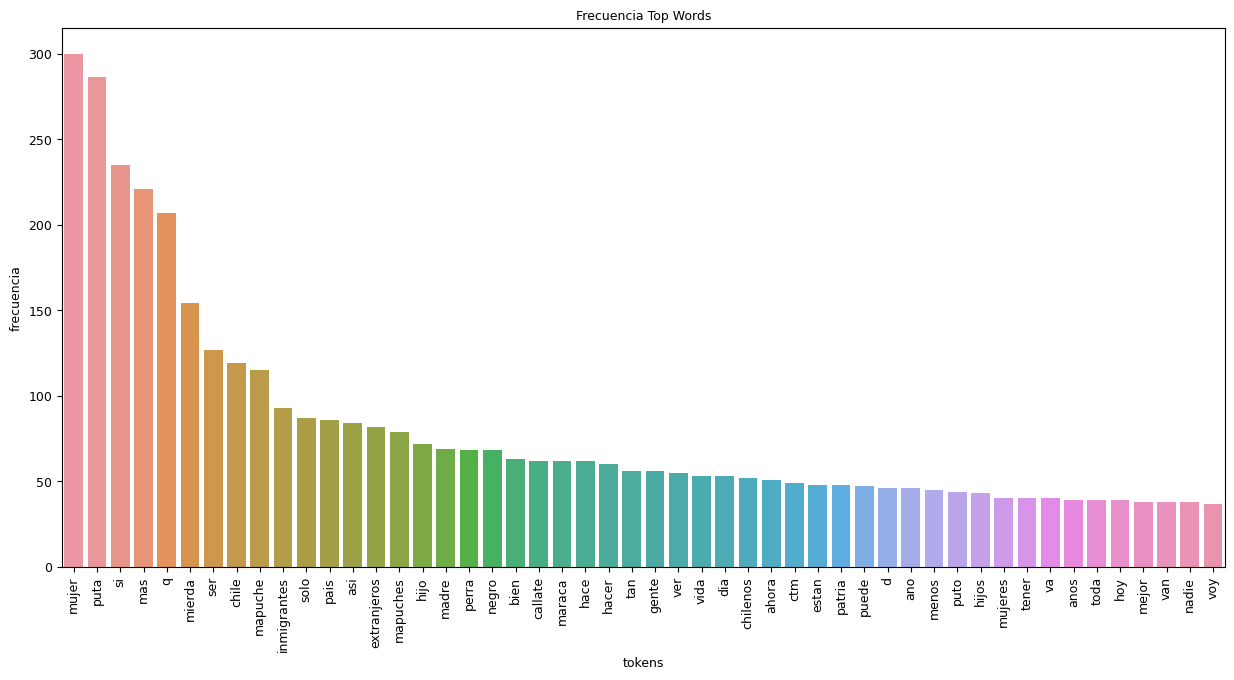

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

n_top_words = 50

tweets= [preprocess(tweet, cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=0).split() for tweet in train_data['text'].values]

top_words = Counter([item for sublist in [tweet for tweet in tweets] for item in sublist]).most_common(n_top_words)

fig, ax = plt.subplots(figsize=(15,7),nrows=1)
ax.set_title('Frecuencia Top Words',fontsize=9)
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words])
ax.set_xlabel("tokens",fontsize=9)
ax.set_ylabel("frecuencia",fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=90)
plt.show()

# Definición de modelo y datos a usar

In [184]:
CLEANING = True
STOPWORDS = False
STEMMING = False
LEMMATIZER = False
LEN_WORDS = 0

train_tweets = [preprocess(tweet, cleaning=CLEANING, stopwords=STOPWORDS, stemming=STEMMING, lemmatizer=LEMMATIZER, len_words=LEN_WORDS) for tweet in train_data['text'].values]
val_tweets = [preprocess(tweet) for tweet in val_data['text'].values]
y_train_categorias = train_data[classes].values
y_val_categorias = val_data[classes].values

print(y_train_categorias.shape)
print(y_val_categorias.shape)

(1917, 4)
(339, 4)


In [185]:
# calculate the 90th percentile for tweet length
tweet_lengths = [len(tweet.split()) for tweet in train_tweets]
tweet_lengths.sort()
print("99th percentile tweet length:",tweet_lengths[int(len(tweet_lengths)*0.99)])

99th percentile tweet length: 54


In [186]:
import datasets

train_dataset =  datasets.Dataset.from_pandas(pd.DataFrame(data=train_tweets, columns=["text"]))
val_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=val_tweets, columns=["text"]))

y_train = np.array(y_train_categorias)
y_val = np.array(y_val_categorias)

In [187]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_dataset(data):
    return tokenizer(data["text"], return_tensors="np", padding=True, truncation=True, max_length=56)

train_dataset = train_dataset.map(tokenize_dataset)

In [188]:
print(train_dataset)

Dataset({
    features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1917
})


In [ ]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
tf_dataset = model.prepare_tf_dataset(train_dataset, batch_size=16, shuffle=True, tokenizer=tokenizer)
model.compile(optimizer=Adam(3e-5)) 
model.fit(tf_dataset)

# Entrenamiento

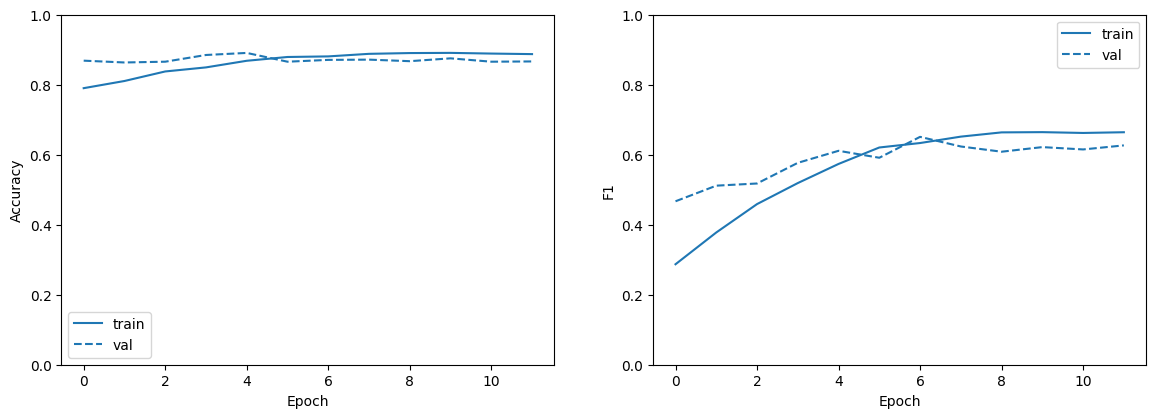

In [21]:
plot_metrics(history_bert_model)

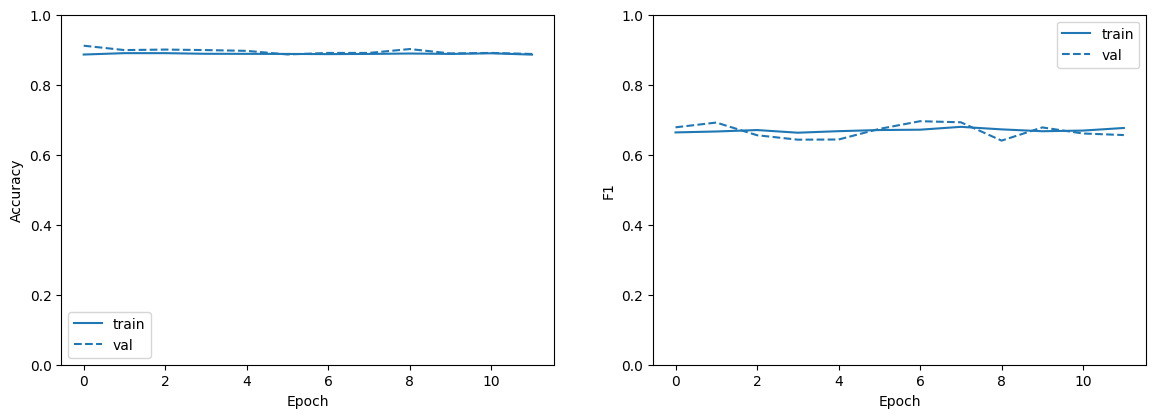

In [25]:
plot_metrics(history_bert_model)

# Predicciones

In [109]:
bert_model = keras.models.load_model('BERT_model/long_train_BERT_5class_F1-0.5997.h5', custom_objects={'KerasLayer':hub.KerasLayer})
test_data = pd.read_csv('data/public_test.csv')
test_tweets = [preprocess(tweet, cleaning=CLEANING, stopwords=STOPWORDS, stemming=STEMMING, lemmatizer=LEMMATIZER, len_words=LEN_WORDS) for tweet in test_data['text'].values]
bert_input_test = prepare_input_for_bert(test_tweets,bert_tokenizer,max_seq_len)

y_pred_categorias = bert_model.predict(bert_input_test)
for row in y_pred_categorias:
    for i in range(len(classes)):
        if row[i] > 0.5:
            row[i] = 1
        else:
            row[i] = 0
y_pred_categorias = pd.DataFrame(y_pred_categorias, columns=[classes])

72/72 [==============================] - 4s 50ms/step


In [185]:
def contar_odio(nombre_columna):
    contador = 0
    for i in range(len(y_pred_categorias)):
        if y_pred_categorias[nombre_columna].iloc[i].item()==1:
            if y_pred_categorias["Odio"].iloc[i].item()==1:
                contador += 1
    return contador 

print(list(y_pred_categorias.sum(axis=0)))

[1252.0, 483.0, 248.0, 328.0, 330.0]


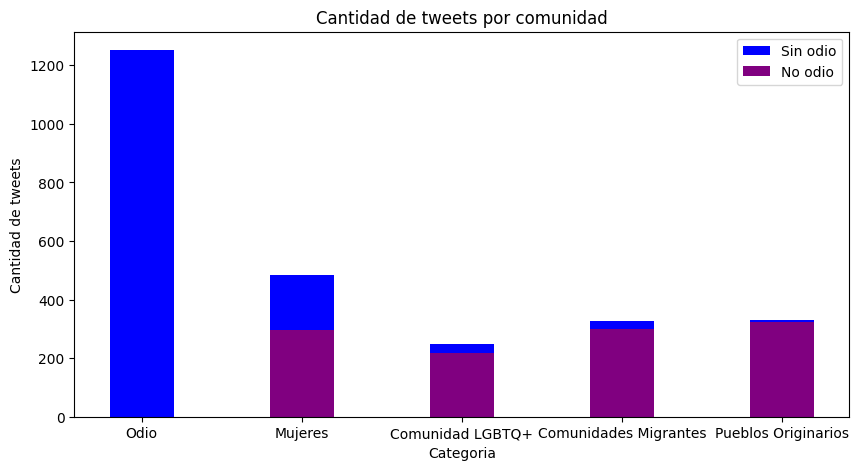

In [191]:
[num_odio, num_mujeres, num_lgbt, num_migrantes, num_pueblos] =list(y_pred_categorias.sum(axis=0))
odio_mujeres = contar_odio("Mujeres")
odio_lgbt = contar_odio("Comunidad LGBTQ+")
odio_migrantes = contar_odio("Comunidades Migrantes")
odio_pueblos = contar_odio("Pueblos Originarios")

# plot the data of each community with odio and without odio
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(classes, [0, num_mujeres, num_lgbt, num_migrantes, num_pueblos], label='No odio', color='blue', width=0.4)
ax.bar(classes, [num_odio, odio_mujeres, odio_lgbt, odio_migrantes, odio_pueblos], label='Odio', color='purple', width=0.4)
ax.set_ylabel('Cantidad de tweets')
ax.set_xlabel('Categoria')
ax.set_title('Cantidad de tweets por comunidad')
ax.legend()
plt.show()


In [ ]:
y_pred_categorias["tweet_id"] = test_data["tweet_id"]
y_pred_categorias.to_csv('predicciones.csv', index=False)
y_pred_categorias